In [ ]:
!pip install resampy

In [ ]:
!pip install keras

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# --- إعداد المسارات ---
DATA_DIR = "/content/drive/MyDrive/ESC-50-master"
AUDIO_DIR = os.path.join(DATA_DIR, "audio")
CSV_PATH = os.path.join(DATA_DIR, "meta/esc50.csv")

# --- إعدادات الصوت ---
N_MFCC = 40       # عدد الخصائص المستخرجة
MAX_LEN = 174     # طول موحد للمدخلات (يعادل حوالي 4-5 ثواني)
SAMPLE_RATE = 22050

# --- خريطة الكلاسات (Mapping) ---
# سنختار من ESC-50 ما يطابق مشروعك
# rain تم اختياره كخلفية (ضوضاء بيضاء)
TARGET_CLASSES = {
    'glass_breaking': 'glass_break',   # خطر عالي (أمن)
    'siren': 'smoke_alarm',            # خطر عالي (سلامة) - اخترنا السارينة كأقرب شيء للإنذار
    'crying_baby': 'baby_cry',         # رعاية أطفال
    'door_wood_knock': 'door_knock',   # نشاط منزلي
    'vacuum_cleaner': 'vacuum',        # ضوضاء منزلية
    'rain': 'background'               # لا حدث (خلفية صوتية)
}

print("جاري تحميل ومعالجة البيانات... ⏳")

# 1. قراءة ملف الـ CSV وتصفية البيانات
df = pd.read_csv(CSV_PATH)
df_filtered = df[df['category'].isin(TARGET_CLASSES.keys())].copy()

# تحديث أسماء الكلاسات لتناسب مشروعك
df_filtered['category'] = df_filtered['category'].map(TARGET_CLASSES)

print(f"تم العثور على {len(df_filtered)} ملف صوتي للكلاسات المختارة.")

# 2. دالة استخراج الخصائص
def extract_features(filename):
    file_path = os.path.join(AUDIO_DIR, filename)
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

        # توحيد الطول (Padding/Truncating)
        if mfccs.shape[1] < MAX_LEN:
            pad_width = MAX_LEN - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :MAX_LEN]

        return mfccs
    except Exception as e:
        print(f"Error encountered while parsing file: {filename}, {e}")
        return None

# 3. تطبيق الدالة على البيانات
features = []
labels = []

for index, row in df_filtered.iterrows():
    data = extract_features(row['filename'])
    if data is not None:
        features.append(data)
        labels.append(row['category'])

# تحويل القوائم إلى مصفوفات Numpy
X = np.array(features)
y = np.array(labels)

# إعادة تشكيل X ليناسب CNN (Rows, Cols, Channels)
X = X.reshape(X.shape[0], N_MFCC, MAX_LEN, 1)

# تشفير الكلاسات (Label Encoding)
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

# تقسيم البيانات (Training & Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("✅ انتهت معالجة البيانات بنجاح!")
print(f"أبعاد بيانات التدريب: {X_train.shape}")

جاري تحميل ومعالجة البيانات... ⏳
تم العثور على 240 ملف صوتي للكلاسات المختارة.
✅ انتهت معالجة البيانات بنجاح!
أبعاد بيانات التدريب: (192, 40, 174, 1)


In [ ]:
# --- بناء المودل (CNN Architecture) ---
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, MAX_LEN, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(TARGET_CLASSES), activation='softmax') # عدد الكلاسات = 6
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- التدريب ---
print("🚀 بدأ تدريب المودل...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# --- حفظ المودل ---
# 1. حفظ بصيغة Keras (للاستخدام العادي)
model.save('smart_home_sound_model.h5')
print("💾 تم حفظ المودل بصيغة .h5")

# 2. حفظ أسماء الكلاسات (مهم جداً للواجهة)
np.save('classes.npy', le.classes_)
print("💾 تم حفظ أسماء الكلاسات في classes.npy")

# 3. (اختياري) تحويل وحفظ بصيغة TFLite للسرعة القصوى (Real-time)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('smart_home_sound_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("⚡ تم حفظ المودل بصيغة .tflite (محسن للـ Real-time)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🚀 بدأ تدريب المودل...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 366ms/step - accuracy: 0.4145 - loss: 2.0828 - val_accuracy: 0.2708 - val_loss: 10.0758
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8141 - loss: 0.5202 - val_accuracy: 0.4167 - val_loss: 4.4220
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8967 - loss: 0.2833 - val_accuracy: 0.5000 - val_loss: 3.3915
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9243 - loss: 0.1833 - val_accuracy: 0.5625 - val_loss: 2.2463
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9588 - loss: 0.1742 - val_accuracy: 0.6250 - val_loss: 1.4835
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9604 - loss: 0.0977 - val_accuracy: 0.7292 - val_loss: 0.8982
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9405 - loss: 0.1621 - val_accuracy: 0.7292 - val_loss: 0.6259
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9632 - loss: 0.0820 - val_accuracy: 0

💾 تم حفظ المودل بصيغة .h5
💾 تم حفظ أسماء الكلاسات في classes.npy
Saved artifact at '/tmp/tmpluqexr18'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 174, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133561963349392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963362448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963359952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963359184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963361104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963356496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963360528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963360720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963357648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133561963358992: Ten

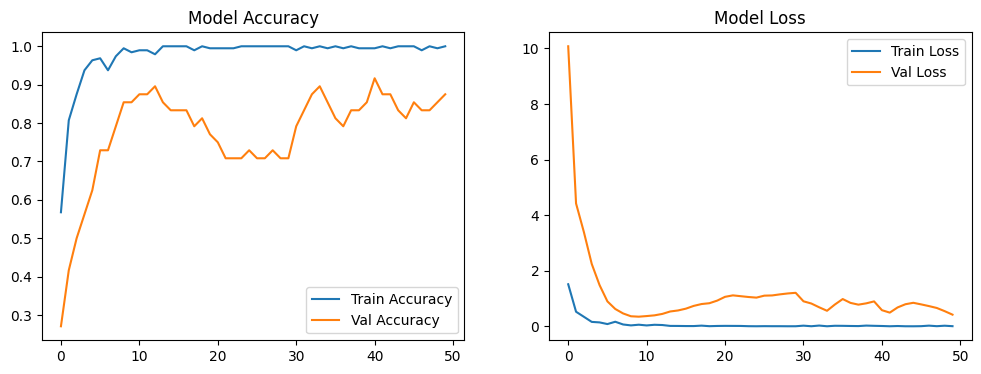

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

--- تقرير التصنيف (Classification Report) ---
              precision    recall  f1-score   support

    baby_cry       1.00      0.75      0.86         8
  background       0.67      1.00      0.80         8
  door_knock       1.00      1.00      1.00        11
 glass_break       0.88      0.78      0.82         9
 smoke_alarm       1.00      1.00      1.00         4
      vacuum       0.86      0.75      0.80         8

    accuracy                           0.88        48
   macro avg       0.90      0.88      0.88        48
weighted avg       0.90      0.88      0.88        48



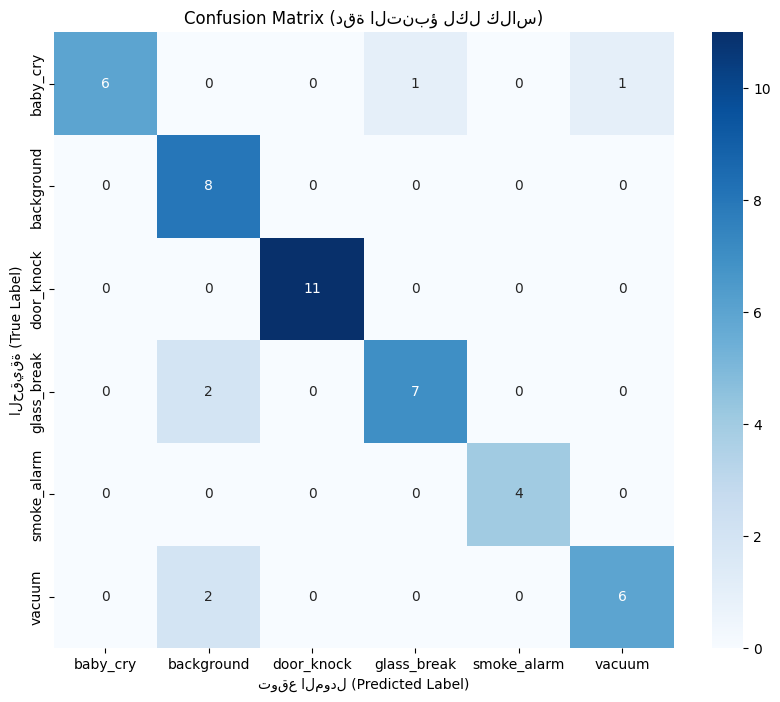

In [ ]:
# --- التقييم ---
# رسم منحنى الدقة والخسارة
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()



#[Image of model accuracy and loss graphs]


# تقرير التصنيف ومصفوفة الارتباك
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n--- تقرير التصنيف (Classification Report) ---")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# رسم مصفوفة الارتباك (Confusion Matrix)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (دقة التنبؤ لكل كلاس)')
plt.ylabel('الحقيقة (True Label)')
plt.xlabel('توقع المودل (Predicted Label)')
plt.show()

### 🚀 اختبار المودل بصوت جديد

الآن بعد تدريب وحفظ المودل، يمكننا اختباره على ملف صوتي جديد. سنقوم بتحميل المودل المحفوظ وأسماء الكلاسات، ثم سنقوم بإنشاء دالة لمعالجة أي ملف صوتي جديد وتوقع الكلاس الذي ينتمي إليه مع عرض مستوى الثقة.

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import os

# تحديد المسارات والثوابت المستخدمة في التدريب
DATA_DIR = "/content/drive/MyDrive/ESC-50-master"
AUDIO_DIR = os.path.join(DATA_DIR, "/content/VOXCry_5 year old child crying 5 (ID 2552)_BSB.wav") # افتراض أن الملف الجديد سيتم وضعه هنا
N_MFCC = 40
MAX_LEN = 174
SAMPLE_RATE = 22050

# 1. تحميل المودل المحفوظ
loaded_model = tf.keras.models.load_model('smart_home_sound_model.h5')
print("✅ تم تحميل المودل بنجاح!")

# 2. تحميل أسماء الكلاسات
loaded_classes = np.load('classes.npy', allow_pickle=True)
print(f"✅ تم تحميل أسماء الكلاسات: {loaded_classes}")

✅ تم تحميل المودل بنجاح!
✅ تم تحميل أسماء الكلاسات: ['baby_cry' 'background' 'door_knock' 'glass_break' 'smoke_alarm' 'vacuum']


In [ ]:
def predict_audio(audio_filepath):
    """
    تستقبل مسار ملف صوتي، تقوم بمعالجته وتتوقع الكلاس الذي ينتمي إليه مع الثقة.
    """
    try:
        # تحميل الصوت واستخراج MFCCs
        audio, sr = librosa.load(audio_filepath, sr=SAMPLE_RATE, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

        # توحيد الطول (Padding/Truncating)
        if mfccs.shape[1] < MAX_LEN:
            pad_width = MAX_LEN - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :MAX_LEN]

        # إعادة تشكيل المدخلات لتناسب المودل (1, N_MFCC, MAX_LEN, 1)
        mfccs = mfccs.reshape(1, N_MFCC, MAX_LEN, 1)

        # التوقع باستخدام المودل
        predictions = loaded_model.predict(mfccs)
        predicted_probabilities = predictions[0]
        predicted_class_index = np.argmax(predicted_probabilities)
        predicted_class_label = loaded_classes[predicted_class_index]
        confidence = predicted_probabilities[predicted_class_index] * 100

        print(f"\nملف الصوت: {os.path.basename(audio_filepath)}")
        print(f"----------------------------------")
        print(f"الكلاس المتوقع: {predicted_class_label}")
        print(f"مستوى الثقة: {confidence:.2f}%")
        print("\nجميع الاحتمالات:")
        for i, prob in enumerate(predicted_probabilities):
            print(f"  {loaded_classes[i]}: {prob*100:.2f}%")

    except Exception as e:
        print(f"حدث خطأ أثناء معالجة ملف الصوت {os.path.basename(audio_filepath)}: {e}")

# مثال على استخدام الدالة (بعد رفع الملف إلى Google Drive):
# قم بتعديل المسار أدناه إلى مسار ملفك الصوتي الذي رفعته.
# يمكنك استبدال 'your_uploaded_audio.wav' بالاسم الفعلي للملف.
# test_audio_path = os.path.join(AUDIO_DIR, 'your_uploaded_audio.wav')
predict_audio(AUDIO_DIR)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

ملف الصوت: VOXCry_5 year old child crying 5 (ID 2552)_BSB.wav
----------------------------------
الكلاس المتوقع: baby_cry
مستوى الثقة: 81.13%

جميع الاحتمالات:
  baby_cry: 81.13%
  background: 0.44%
  door_knock: 0.10%
  glass_break: 4.57%
  smoke_alarm: 12.54%
  vacuum: 1.21%


⚠️ **ملاحظة هامة:**

تأكد من استبدال `# test_audio_path = os.path.join(AUDIO_DIR, 'your_uploaded_audio.wav')` بالمسار الصحيح للملف الصوتي الذي قمت بتحميله في Google Drive الخاص بك (على سبيل المثال، `'/content/drive/MyDrive/ESC-50-master/audio/example_sound.wav'`).